<a href="https://colab.research.google.com/github/jakewalter/frontiers_geophysics/blob/main/earthquake_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install basemap
import pandas as pd
import matplotlib.path as mpltPath
from sklearn.cluster import DBSCAN
from mpl_toolkits.basemap import Basemap
import numpy as np

catdf = pd.read_csv('http://wichita.ogs.ou.edu/eq/catalog/complete/complete.csv')

#eqtempin = catdf[['latitude','longitude']].to_numpy()
#eqpath = mpltPath.Path(polygon)
#insidestate = eqpath.contains_points(eqtempin)
#catdf = catdf[insidestate]

#catdf = catdf.reset_index(drop=True)
catdf['origintime'] = pd.to_datetime(catdf['origintime'])
catdf['magnitude'] = catdf['magnitude'].str.replace("None", "0").astype(float)
catdf['magnitude'] = catdf['magnitude'].astype(float)
#catdf = catdf[(catdf['origintime']>time1) & (catdf['origintime']<time2)]
catdf.sort_values(by=['origintime'], inplace=True)
lat_a = 36.36
lat_b = 36.49
lon_a = -97.01
lon_b = -96.80

catdf = catdf[(catdf['latitude']>lat_a) & (catdf['latitude']<lat_b) & (catdf['longitude']>lon_a) & (catdf['longitude']<lon_b)]

catdf = catdf.reset_index(drop=True)

#


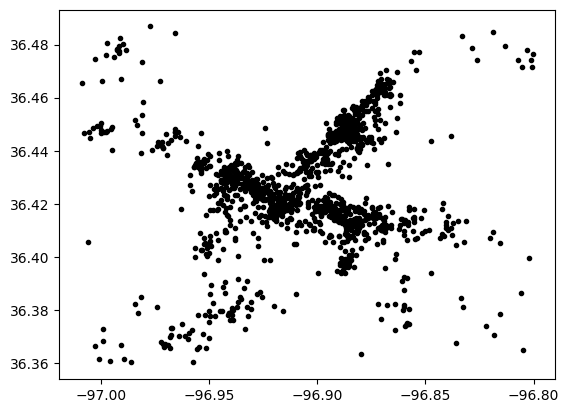

In [2]:
import matplotlib.pyplot as plt
plt.plot(catdf['longitude'], catdf['latitude'],'k.')

Now that we have an earthquake catalog, we seek to cluster the events spatially ...

In [56]:

map = Basemap(llcrnrlon=-104,llcrnrlat=33,urcrnrlon=-93,urcrnrlat=38, resolution='l', projection='tmerc',lat_0=35,lon_0=-98)
x,y = map(np.array((catdf['longitude'])),np.array((catdf['latitude'])))
X=np.transpose(np.array((x,y)))



import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

eps_value = 200
db = DBSCAN(eps=eps_value, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 15
Estimated number of noise points: 651


In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

Once you settle on the appropriate parameters for clustering, we can next attempt to find fault orientations. Note in the last section that we had a loop in order to plot the different clusters. This time, within the loop, let's fit a line.

In [ ]:
from sklearn import linear_model

db = DBSCAN(eps=eps_value, min_samples=10).fit(X)
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k in unique_labels:
    #fig = plt.figure()
    #ax = mplot3d.Axes3D(fig)
    #print(k, col)
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    #xy = X[class_member_mask & ~core_samples_mask]
    #print(xy)


    xy = X[class_member_mask & core_samples_mask]
    if len(xy)>1:    #print(xy)
      x1 = xy[:,0].reshape(-1,1)
      y1 = xy[:,1]


      # Fit line using all data
      lr = linear_model.LinearRegression()
      lr.fit(x1, y1)

      # Robustly fit linear model with RANSAC algorithm
      ransac = linear_model.RANSACRegressor()
      ransac.fit(x1, y1)
      # inlier_mask = ransac.inlier_mask_
      # outlier_mask = np.logical_not(inlier_mask)

      # Predict data of estimated models
      line_X = np.arange(x1.min(), x1.max())[:, np.newaxis]
      line_y = lr.predict(line_X)
      line_y_ransac = ransac.predict(line_X)
      plt.plot(xy[:,0],xy[:,1],'ro')
      plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=2, label='RANSAC regressor')
